In [1]:
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
from glob2 import glob

# PATH = '../einstein.jpg'
PATH = '../1-126.jpg'

### Fuzzification of Pixel Intensity

In [44]:
# Gaussian Function:
def G(x, mean, std):
    return np.exp(-0.5*np.square((x-mean)/std))

# Membership Functions:
def ExtremelyDark(x, M):
    return G(x, -50, M/6)

def VeryDark(x, M):
    return G(x, 0, M/6)

def Dark(x, M):
    return G(x, M/2, M/6)

def SlightlyDark(x, M):
    return G(x, 5*M/6, M/6)

def SlightlyBright(x, M):
    return G(x, M+(255-M)/6, (255-M)/6)

def Bright(x, M):
    return G(x, M+(255-M)/2, (255-M)/6)

def VeryBright(x, M):
    return G(x, 255, (255-M)/6)

def ExtremelyBright(x, M):
    return G(x, 305, (255-M)/6)

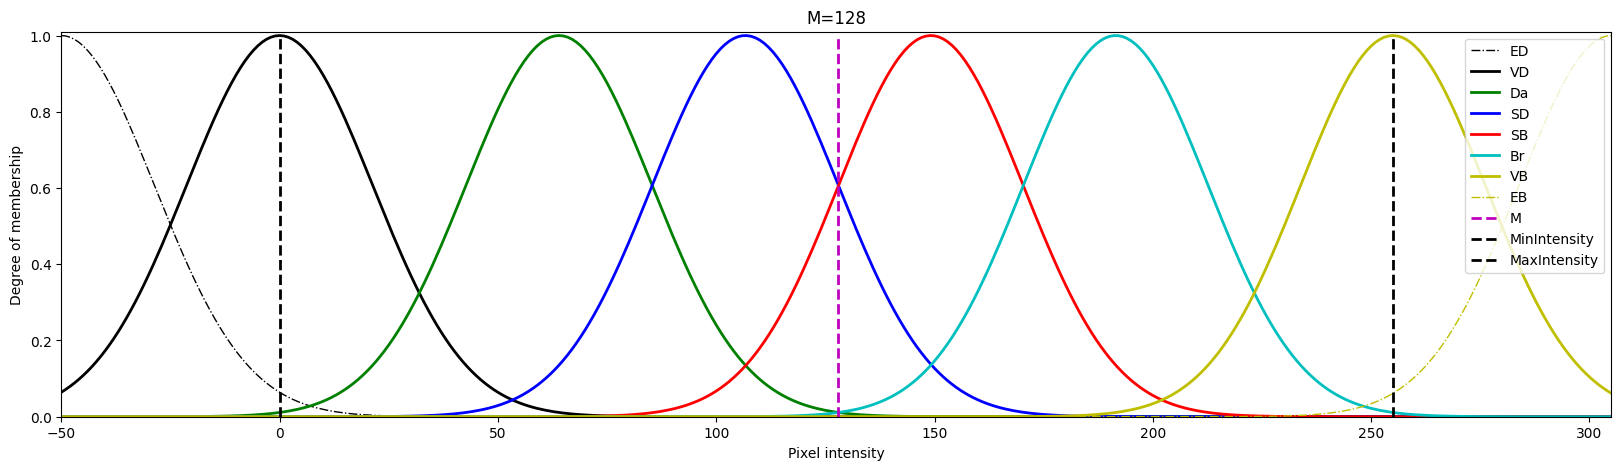

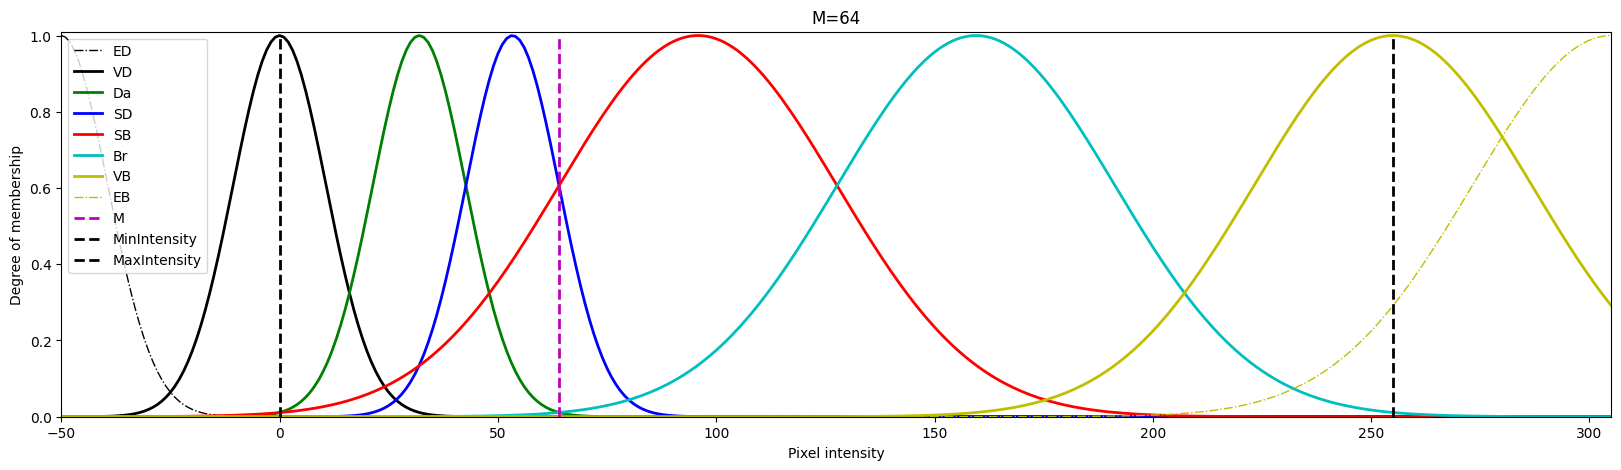

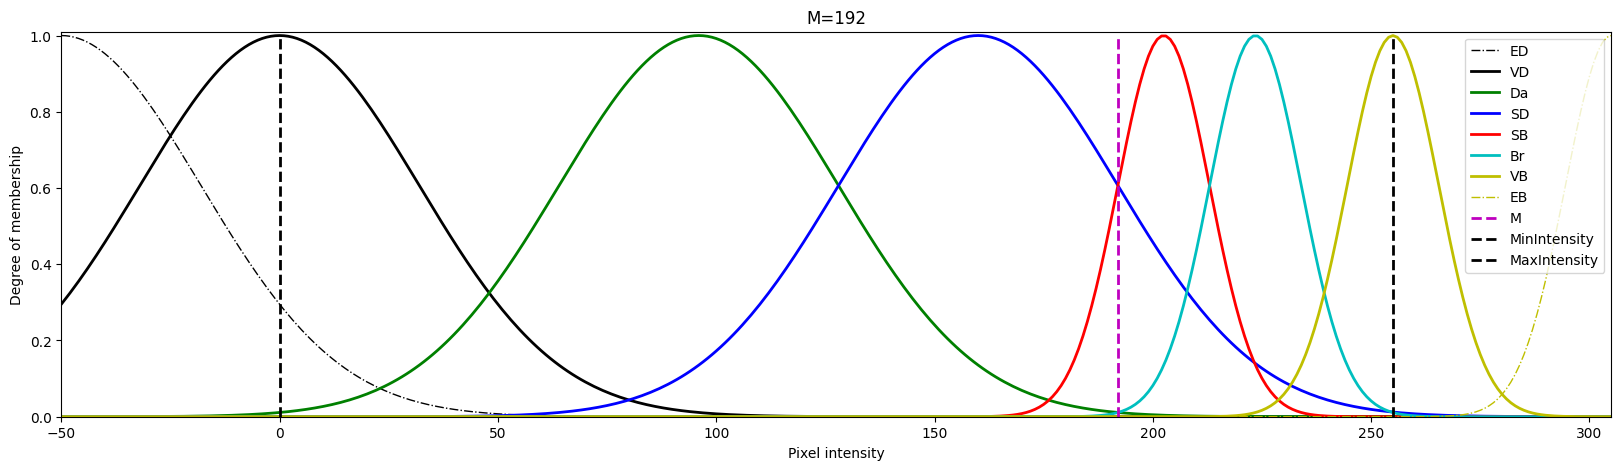

In [3]:
for M in (128, 64, 192):
    x = np.arange(-50, 306)
    
    ED = ExtremelyDark(x, M)
    VD = VeryDark(x, M)
    Da = Dark(x, M)
    SD = SlightlyDark(x, M)
    SB = SlightlyBright(x, M)
    Br = Bright(x, M)
    VB = VeryBright(x, M)
    EB = ExtremelyBright(x, M)

    plt.figure(figsize=(20,5))
    plt.plot(x, ED, 'k-.',label='ED', linewidth=1)
    plt.plot(x, VD, 'k-',label='VD', linewidth=2)
    plt.plot(x, Da, 'g-',label='Da', linewidth=2)
    plt.plot(x, SD, 'b-',label='SD', linewidth=2)
    plt.plot(x, SB, 'r-',label='SB', linewidth=2)
    plt.plot(x, Br, 'c-',label='Br', linewidth=2)
    plt.plot(x, VB, 'y-',label='VB', linewidth=2)
    plt.plot(x, EB, 'y-.',label='EB', linewidth=1)
    plt.plot((M, M), (0, 1), 'm--', label='M', linewidth=2)
    plt.plot((0, 0), (0, 1), 'k--', label='MinIntensity', linewidth=2)
    plt.plot((255, 255), (0, 1), 'k--', label='MaxIntensity', linewidth=2)
    plt.legend()
    plt.xlim(-50, 305)
    plt.ylim(0.0, 1.01)
    plt.xlabel('Pixel intensity')
    plt.ylabel('Degree of membership')
    plt.title(f'M={M}')
    plt.show()

### Inference and Defuzzication (Mamdani's method)

In [4]:
def OutputFuzzySet(x, f, M, thres):
    x = np.array(x)
    result = f(x, M)
    result[result > thres] = thres
    return result

def AggregateFuzzySets(fuzzy_sets):
    return np.max(np.stack(fuzzy_sets), axis=0)

def Infer(i, M, get_fuzzy_set=False):
    # Calculate degree of membership for each class
    VD = VeryDark(i, M)
    Da = Dark(i, M)
    SD = SlightlyDark(i, M)
    SB = SlightlyBright(i, M)
    Br = Bright(i, M)
    VB = VeryBright(i, M)
    
    # Fuzzy Inference:
    x = np.arange(-50, 306)
    Inferences = (
        OutputFuzzySet(x, ExtremelyDark, M, VD),
        OutputFuzzySet(x, VeryDark, M, Da),
        OutputFuzzySet(x, Dark, M, SD),
        OutputFuzzySet(x, Bright, M, SB),
        OutputFuzzySet(x, VeryBright, M, Br),
        OutputFuzzySet(x, ExtremelyBright, M, VB)
    )
    
    # Calculate AggregatedFuzzySet:
    fuzzy_output = AggregateFuzzySets(Inferences)
    
    # Calculate crisp value of centroid
    if get_fuzzy_set:
        return np.average(x, weights=fuzzy_output), fuzzy_output
    return np.average(x, weights=fuzzy_output)

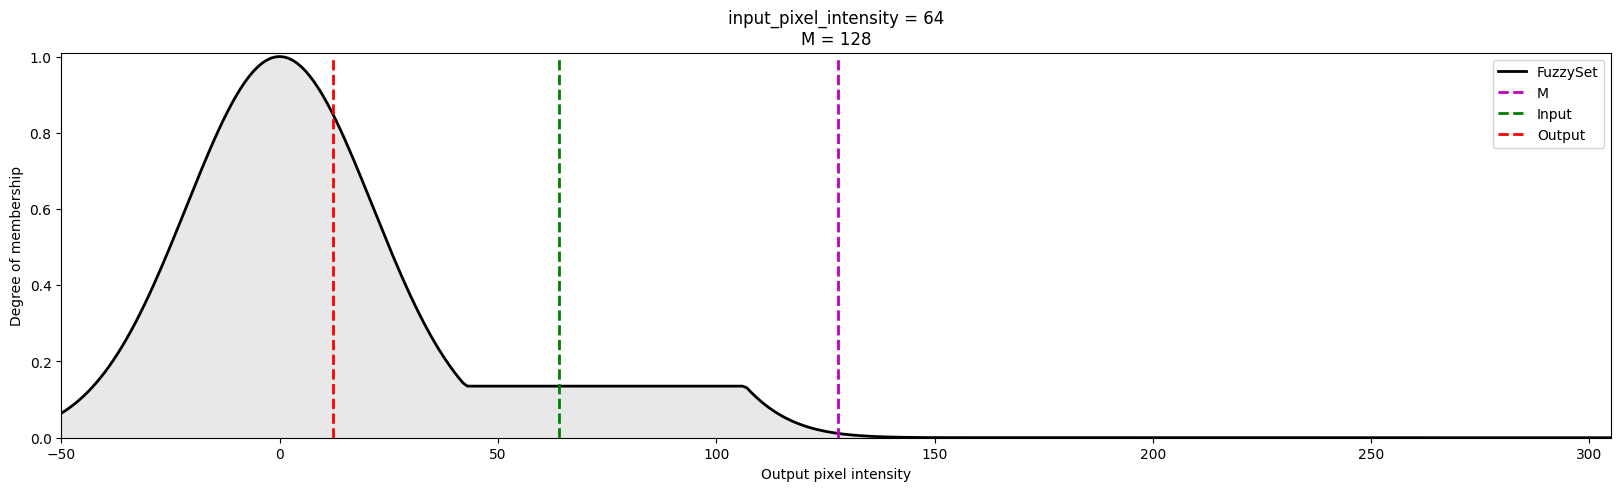

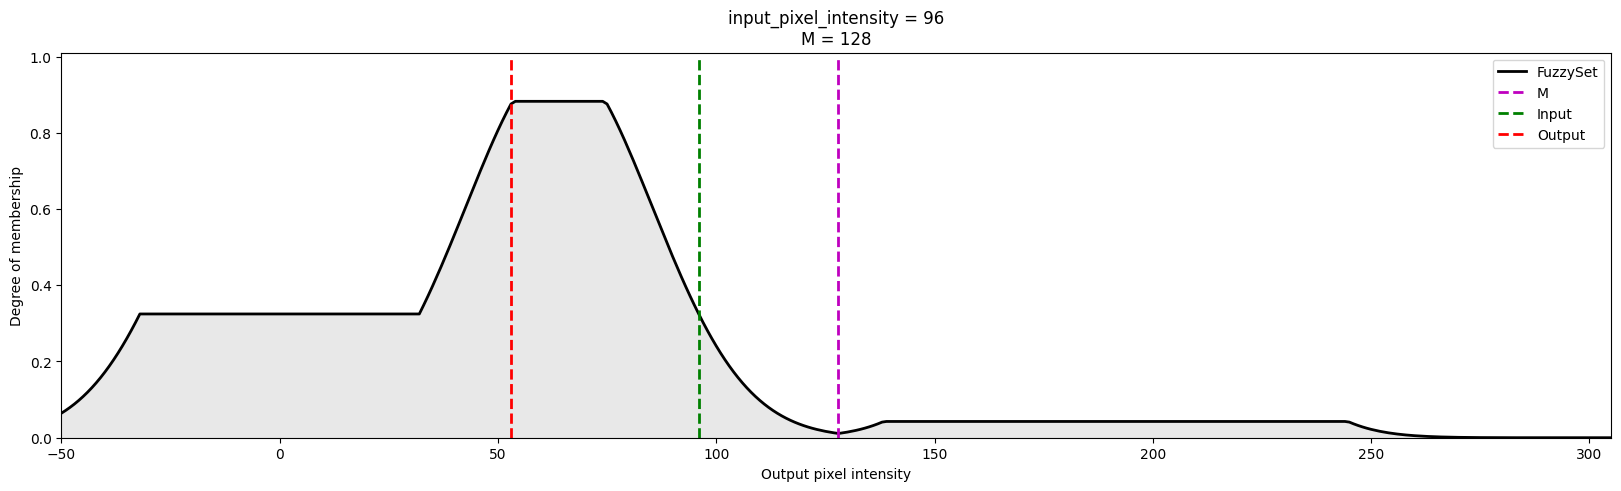

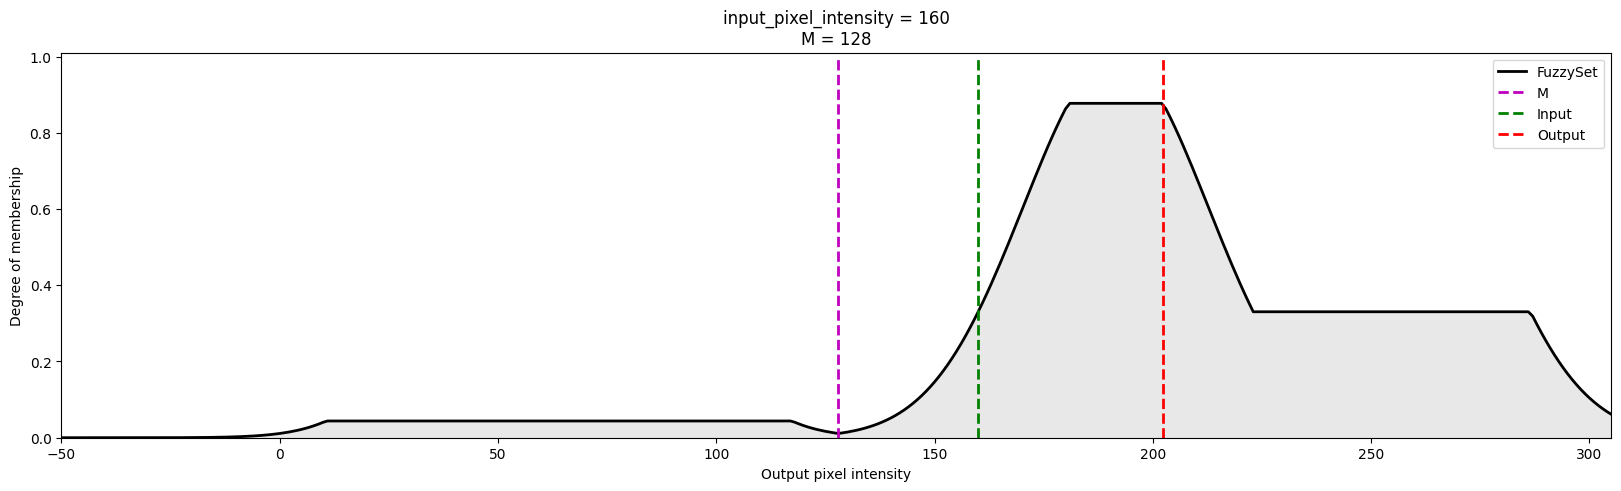

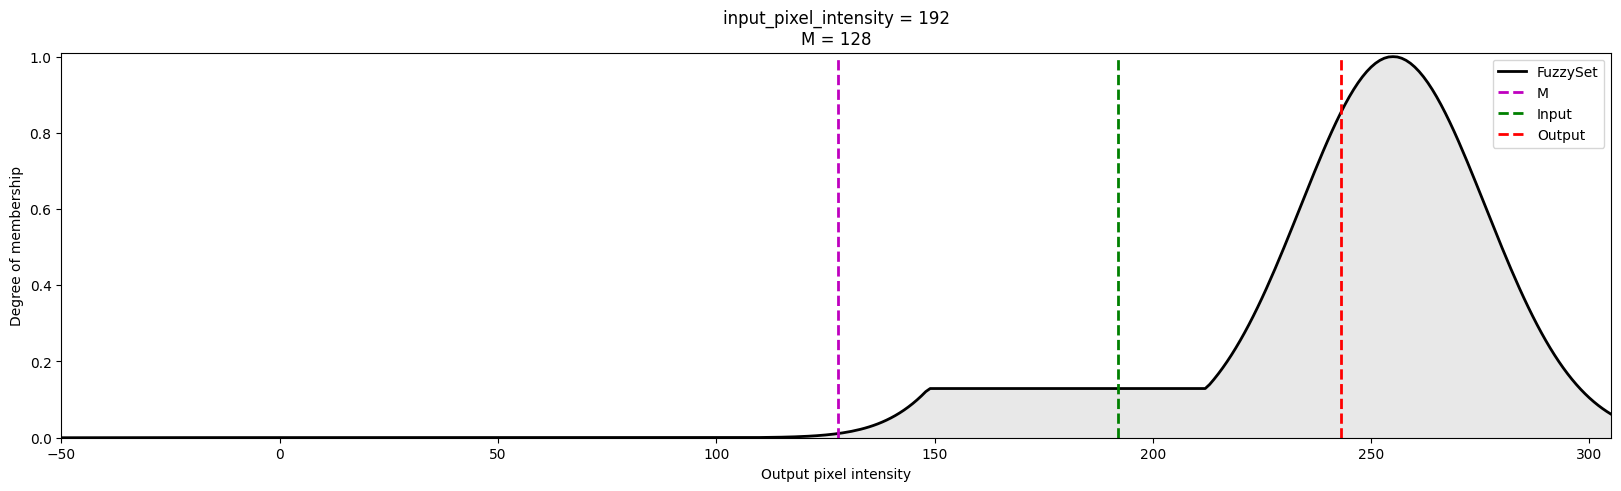

In [5]:
for pixel in (64, 96, 160, 192):
    M = 128
    x = np.arange(-50, 306)
    centroid, output_fuzzy_set = Infer(np.array([pixel]), M, get_fuzzy_set=True)
    plt.figure(figsize=(20,5))
    plt.plot(x, output_fuzzy_set, 'k-',label='FuzzySet', linewidth=2)
    plt.plot((M, M), (0, 1), 'm--', label='M', linewidth=2)
    plt.plot((pixel, pixel), (0, 1), 'g--', label='Input', linewidth=2)
    plt.plot((centroid, centroid), (0, 1), 'r--', label='Output', linewidth=2)
    plt.fill_between(x, np.zeros(356), output_fuzzy_set, color=(.9, .9, .9, .9))
    plt.legend()
    plt.xlim(-50, 305)
    plt.ylim(0.0, 1.01)
    plt.xlabel('Output pixel intensity')
    plt.ylabel('Degree of membership')
    plt.title(f'input_pixel_intensity = {pixel}\nM = {M}')
    plt.show()

CPU times: total: 15.6 ms
Wall time: 21 ms
CPU times: total: 0 ns
Wall time: 19.1 ms
CPU times: total: 0 ns
Wall time: 20.2 ms
CPU times: total: 0 ns
Wall time: 20.1 ms
CPU times: total: 0 ns
Wall time: 20.8 ms


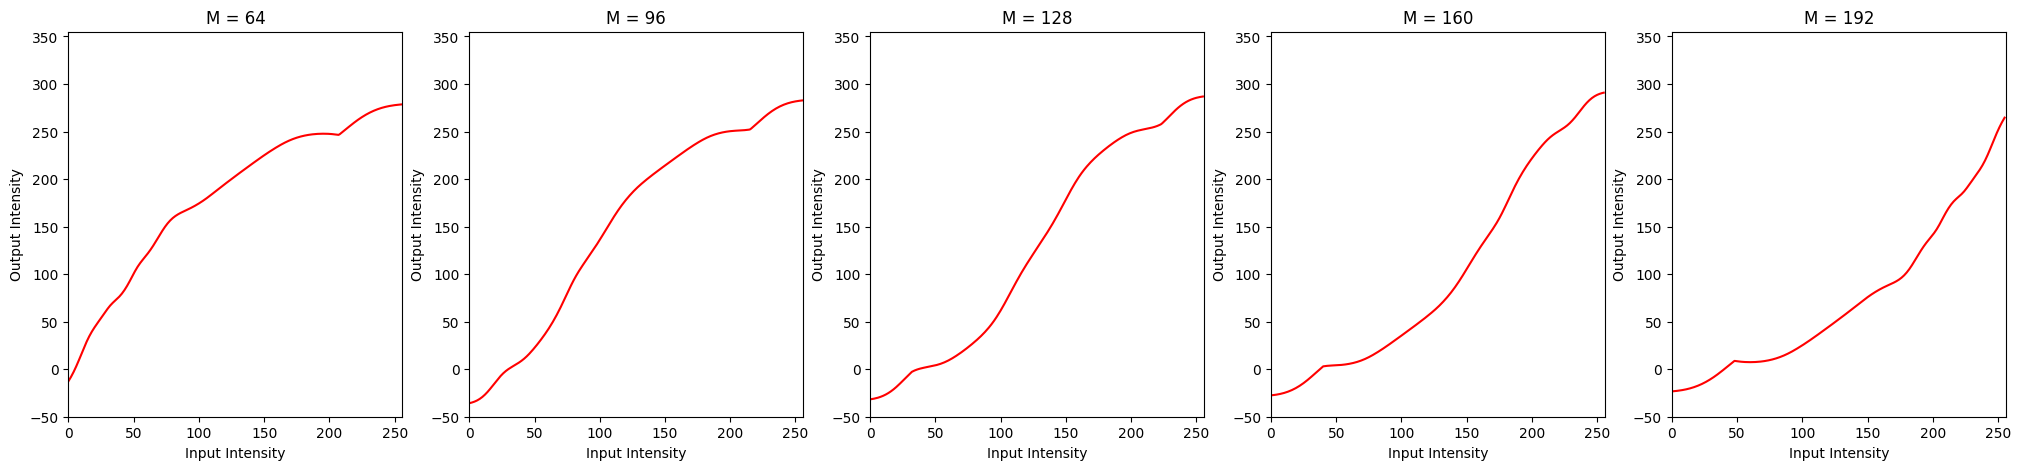

In [6]:
means = (64, 96, 128, 160, 192)
plt.figure(figsize=(25,5))
for i in range(len(means)):
    M = means[i]
    x = np.arange(256)
    %time y = np.array([Infer(np.array([i]), M) for i in x])
    plt.subplot(1, len(means), i+1)
    plt.plot(x, y, 'r-', label='IO mapping')
    plt.xlim(0, 256)
    plt.ylim(-50, 355)
    plt.xlabel('Input Intensity')
    plt.ylabel('Output Intensity')
    plt.title(f'M = {M}')
plt.show()

### Demostration

In [7]:
# Proposed fuzzy method
def FuzzyContrastEnhance(rgb):
    # Convert RGB to LAB
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    
    # Get L channel
    l = lab[:, :, 0]
    
    # Calculate M value
    M = np.mean(l)
    if M < 128:
        M = 127 - (127 - M)/2
    else:
        M = 128 + M/2
        
    # Precompute the fuzzy transform
    x = list(range(-50,306))
    FuzzyTransform = dict(zip(x,[Infer(np.array([i]), M) for i in x]))
    
    # Apply the transform to l channel
    u, inv = np.unique(l, return_inverse = True)
    l = np.array([FuzzyTransform[i] for i in u])[inv].reshape(l.shape)
    
    # Min-max scale the output L channel to fit (0, 255):
    Min = np.min(l)
    Max = np.max(l)
    lab[:, :, 0] = (l - Min)/(Max - Min) * 255
    
    # Convert LAB to RGB
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Traditional method of histogram equalization
def HE(rgb):
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab[:, :, 0] = cv2.equalizeHist(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# Contrast Limited Adaptive Histogram Equalization
def CLAHE(rgb):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

### Load sample photos

In [8]:
# Carica l'immagine
image = cv2.imread(PATH)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
data.shape

NameError: name 'data' is not defined

### Apply FCE on sample photos

### <p style="text-align: center;">Sample Photo 5</p>

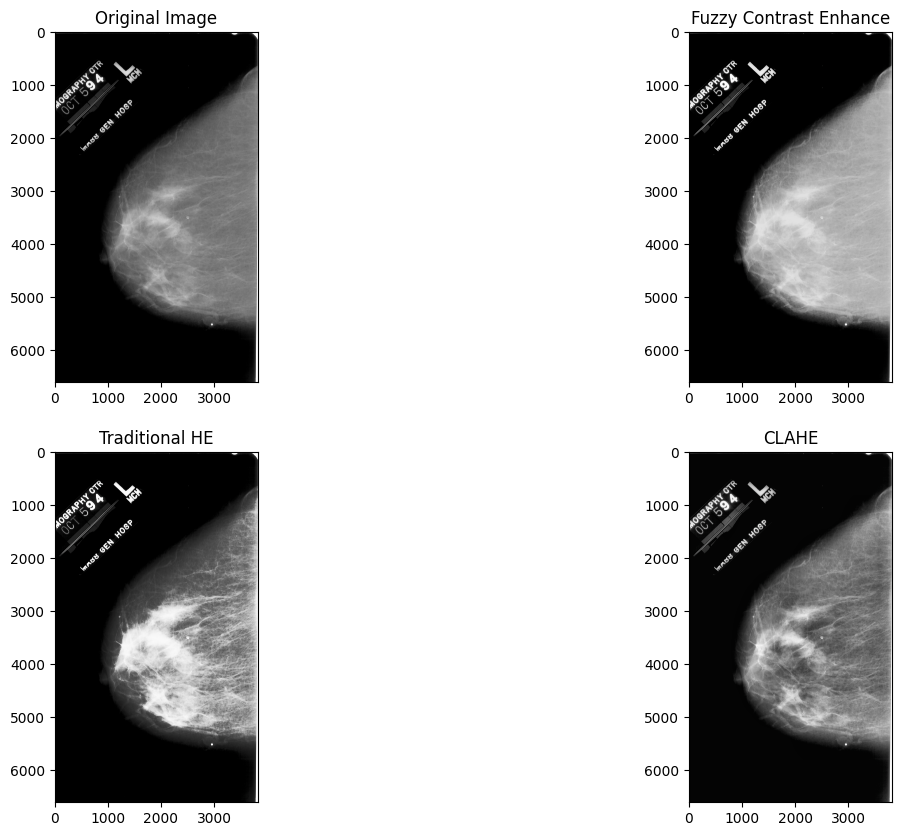

In [9]:
img = image_rgb
fce = FuzzyContrastEnhance(image_rgb)
he = HE(image_rgb)
clahe = CLAHE(image_rgb) 
display(Markdown(f'### <p style="text-align: center;">Sample Photo {i+1}</p>'))
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(2, 2, 2)
plt.imshow(fce)
plt.title('Fuzzy Contrast Enhance')

plt.subplot(2, 2, 3)
plt.imshow(he)
plt.title('Traditional HE')

plt.subplot(2, 2, 4)
plt.imshow(clahe)
plt.title('CLAHE')

plt.show()